### Basics-

1) Tokens are numerical mappings of the text. They can be characters, sub-words, combinations of characters and subwords, etc
    When tokenizing text,  each sentence will be 1 batch. If you want multiple batches, create a list of sentences
2) Embeddings are vector space representations of tokens. An embdedding space essentially has a mapping of tokens to embeddings (vectors) through a logic-
    Embedding layer syntax: nn.Embedding(num_embeddings=vocab_size, embedding_dim= embedding_dim)
    Here, we define the embedding dimensions, i.e to what dimension we want to map our text- and we generally call it hidden size as it is the dimension of the space that is hidden from the user
    Vocab size is also defined by us if we use a custom tokenizer, but a standard one will already have a vocab_size mapped
3) Scaled Dot product attention
4) Single head attention-
- What is independent attention mechanism?
    - It is a projection of the input embeddings into a low dimension space represented by head_dim, and it learns one specific feature of the sequence (like subject verb, active passive etc)

5) Multihead attention
    - each attention head has a linear mapping from embedding dimensions to head dimensions
    - This mapping is done on the entire sequence of embedded tokens in each batch
    - We use this mapped value (of q,v and k) from the head and compute the similarity between the query and the key and then scale it using softmax
    - We use this scaled dot product (attention scores) to take a dot product with the value and give us the updated embeddings that essentially give us the original embedding including some context of the past and future sequence
    - After calculating the updated values for one head, we repeat for all heads and then concatenate all heads along the last dimension, which is the head dimension. When we concatenate, we get the original embedding space back, but with added context. we get output with dimensions [batch, sequence, embedding dimensions]

  
6) After getting the output of multihead attention, we first create a transformer encoder layer. First, we add a residual connection (by adding multihead output to original string embeddings)
7) We then do a layer normalization (since we did addition) to bring back the embeddings to mean 0. We also stabilize the data for training so that there are no vanishing gradients
8) After this, each token embedding goes through a feed forward network
    - First mapping is from hidden dimensions (input embedding dimensions) to intermediate dimensions (larger space) to capture nuances
    - Next we apply ReLU activation to introduce non linearity to learn complex relationship. If we don't do this, the entire attention model will be based on linear transformations
    - The last mapping is converting the input embeddings in intermediate dimension back to the original dimensions (we basically assume that the transformations will incorporate the patterns and relations learned in the higher dimensional space
9) We again perform a residual connection (adding feed forward output to original embeddings) and layer normalization
    
10) After creating the transformer encoder layer, we create a transformer encoder, for which we would need to add positional embeddings so that the transformer knows the position of a particular embedding in a sequence, which can allow it to learn more relations
    - To add positional embeddings, we need a way to engineer values such that they are normalized and unique
    - We use cos and sin approach for odd and even index values respectively
    - Before using the cos and sin functions, we need to calculate a unique normalized number for each position. We create a divisor for all even numbers (we can do it only for odd as well but we don't need to do for both as sin and cos phase shift would take care of it)
    - Note that we use cos and sin functions on a multiplication  of divisor with the absolute position (somewhere betwen 0 to max length)
    - After adding the cos and sin functions to create positional embeddings, we add it to a buffer so that it doesnt change when model is being trained (as this function will be called multiple times)
    - We then add these positional embeddings to the original input embedding vector
    - It is definitely mind boggling, I don't get how adding two vectors would help the algo figure out a position. But it seems to be working


In [1]:
from torch import nn
from transformers import AutoTokenizer, AutoConfig
import torch
import torch.nn.functional as F
from math import sqrt
import math
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Encoder

In [2]:
# Tokenization

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = 'I love data science.'
text2= 'I like machine learning.'
print(tokenizer([text, text2], add_special_tokens=False, return_tensors='pt'))
inputs = tokenizer([text, text2], add_special_tokens=False, return_tensors='pt')

{'input_ids': tensor([[1045, 2293, 2951, 2671, 1012],
        [1045, 2066, 3698, 4083, 1012]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])}


In [3]:
# Embedding configurations


config= AutoConfig.from_pretrained('bert-base-uncased')
print(config)

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.45.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [4]:

token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
print(token_embeddings)

Embedding(30522, 768)


In [5]:
input_embeds= token_embeddings(inputs.input_ids)
print(input_embeds.size())

torch.Size([2, 5, 768])


In [6]:
## Calculating Attention Scores

#query = key = value = input_embeds

# function to calculate attention weights that are used to produce updated embeddings
def scaled_dot_product_attention(query,key, value, mask=None):
    dim_k = query.size(-1)

    # attention scores; each element represents the similarity between tokens via dot product, and the output is scaled by root(dimension of key) so as to keep the dot product less and training stable
    scores= torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
            
    weights = F.softmax(scores, dim= -1)
    updated_embeddings= torch.bmm(weights, value)
    return updated_embeddings

# these updated embeddings actually account for all the tokens in that sequence other than the token at that position
# updated_embeddings= scaled_dot_product_attention(query,key,value)
# print(updated_embeddings.size())

In [7]:
## Single attention head

class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)
    
    def forward(self, hidden_state, mask=None):
        attn_outputs = scaled_dot_product_attention(self.q(hidden_state), self.k(hidden_state), self.v(hidden_state), mask)
        return attn_outputs
 

In [8]:
## Multi attention head

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList([AttentionHead(embed_dim, head_dim) for _ in range(num_heads)])
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, hidden_state, mask=None):
        # This concatenation is happening on the last dimension for all heads, which basically means we are getting back to the embedding dimensions
        x = torch.cat([h(hidden_state, mask) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

In [9]:
# class MultiHeadAttention(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         embed_dim = config.hidden_size
#         num_heads = config.num_attention_heads
#         self.head_dim = embed_dim // num_heads
#         self.num_heads = num_heads
        
#         # Linear projections for queries, keys, and values
#         self.q_proj = nn.Linear(embed_dim, embed_dim)
#         self.k_proj = nn.Linear(embed_dim, embed_dim)
#         self.v_proj = nn.Linear(embed_dim, embed_dim)
        
#         # Final linear layer
#         self.output_linear = nn.Linear(embed_dim, embed_dim)
    
#     def scaled_dot_product_attention(self, query, key, value, mask=None):
#         dim_k = query.size(-1)
#         scores = torch.matmul(query, key.transpose(-2, -1)) / sqrt(dim_k)  # Calculate attention scores
        
#         # Apply the mask, if provided
#         if mask is not None:
#             scores = scores.masked_fill(mask == 0, float('-inf'))
        
#         # Calculate attention weights and apply to value
#         attn_weights = F.softmax(scores, dim=-1)
#         output = torch.matmul(attn_weights, value)
#         return output
    
#     def forward(self, query, key, value, mask=None):
#         batch_size = query.size(0)
        
#         # Linear projections and reshaping for multi-head attention
#         query = self.q_proj(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
#         key = self.k_proj(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
#         value = self.v_proj(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
#         # Scaled dot-product attention
#         attn_output = self.scaled_dot_product_attention(query, key, value, mask=mask)  # Ensure mask is passed as keyword argument
        
#         # Concatenate attention output from each head and apply final linear layer
#         attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
#         output = self.output_linear(attn_output)
        
#         return output


In [10]:
# Transformer Encoding Layer to incorporate more context and non linearity

class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.multihead_attn = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(config.hidden_size)
        
        # Feed-forward network
        self.feed_forward = nn.Sequential(
            nn.Linear(config.hidden_size, config.intermediate_size),
            nn.ReLU(),
            nn.Linear(config.intermediate_size, config.hidden_size),
        )
        
        self.layer_norm2 = nn.LayerNorm(config.hidden_size)
    
    def forward(self, hidden_state):
        # Multi-head attention with residual connection and layer normalization
        attn_output = self.multihead_attn(hidden_state)
        hidden_state = self.layer_norm1(hidden_state + attn_output)
        
        # Feed-forward network with residual connection and layer normalization
        ffn_output = self.feed_forward(hidden_state)
        hidden_state = self.layer_norm2(hidden_state + ffn_output)
        
        return hidden_state


In [11]:
# Positional Encoding

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()
        
        # Create a large positional encoding matrix of shape (max_len, embed_dim)
        # Convert a consecutive list of numbers to column matrix
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim))
        
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register buffer so it doesn't get updated during backpropagation
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input tensor
        x = x + self.pe[:x.size(1), :].unsqueeze(0)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Positional encoding will be added before passing inputs to layers
        self.positional_encoding = PositionalEncoding(config.hidden_size, config.max_position_embeddings)
        
        # Stack of encoder layers
        self.layers = nn.ModuleList([TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_state, src_mask= None):
        # Add positional encoding to input embeddings
        hidden_state = self.positional_encoding(hidden_state)
        
        # Pass through each encoder layer in the stack
        for layer in self.layers:
            hidden_state = layer(hidden_state)
        
        return hidden_state


In [12]:
# # Instantiate the encoder with the configuration
# encoder = TransformerEncoder(config)

# # Pass the initial embeddings through the encoder
# encoder_output = encoder(input_embeds)

# print(encoder_output.size())  # Expected output: [batch size, sequence length, embedding dimension]


# Decoder

In [13]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        
        # Masked self-attention for the decoder
        self.self_attention = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        
        # Encoder-decoder attention
        self.encoder_attention = MultiHeadAttention(config)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        
        # Feed-forward network
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, config.intermediate_size),
            nn.ReLU(),
            nn.Linear(config.intermediate_size, embed_dim)
        )
        self.layer_norm3 = nn.LayerNorm(embed_dim)

    def forward(self, hidden_state, encoder_output, tgt_mask=None, memory_mask=None):
        # Masked self-attention: attends to previous tokens only
        attn_output = self.self_attention(hidden_state, mask=tgt_mask)
        hidden_state = self.layer_norm1(hidden_state + attn_output)
        
        # Encoder-decoder attention: attends to the encoder's output
        enc_dec_attn_output = self.encoder_attention(hidden_state, encoder_output, encoder_output, mask=memory_mask)
        hidden_state = self.layer_norm2(hidden_state + enc_dec_attn_output)
        
        # Feed-forward network
        ffn_output = self.feed_forward(hidden_state)
        hidden_state = self.layer_norm3(hidden_state + ffn_output)
        
        return hidden_state


In [14]:
class TransformerDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.positional_encoding = PositionalEncoding(config.hidden_size, config.max_position_embeddings)
        self.layers = nn.ModuleList([TransformerDecoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, tgt_embeds, encoder_output, tgt_mask=None, memory_mask=None):
        # Add positional encoding to the target embeddings
        hidden_state = self.positional_encoding(tgt_embeds)
        
        # Pass through each decoder layer
        for layer in self.layers:
            hidden_state = layer(hidden_state, encoder_output, tgt_mask=tgt_mask, memory_mask=memory_mask)
        
        return hidden_state


In [15]:
class TransformerForSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.embedding = nn.Embedding(vocab_size, hidden_size)  # Embedding layer to map token IDs to embeddings
        self.output_linear = nn.Linear(hidden_size, vocab_size)  # Final linear layer to predict token logits

    def forward(self, src_ids, tgt_ids, src_mask=None, tgt_mask=None, memory_mask=None):
        # Apply embedding layer to convert token IDs to embeddings
        src_embeds = self.embedding(src_ids)  # Shape: [batch size, src_seq_len, hidden_size]
        tgt_embeds = self.embedding(tgt_ids)  # Shape: [batch size, tgt_seq_len, hidden_size]
        
        # Pass through encoder and decoder
        encoder_output = self.encoder(src_embeds, src_mask)
        decoder_output = self.decoder(tgt_embeds, encoder_output, tgt_mask, memory_mask)
        
        # Project decoder output to vocabulary size for logits
        logits = self.output_linear(decoder_output)
        
        return logits


# Using Pretrained models

In [16]:
# def remove_non_ascii(input_file, output_file):
#     try:
#         with open(input_file, 'r', encoding='utf-8') as file:
#             text = file.read()
        
#         # Removing non-ASCII characters
#         cleaned_text = ''.join([char if ord(char) < 128 else '' for char in text])
        
#         # Writing cleaned content to output file
#         with open(output_file, 'w', encoding='utf-8') as file:
#             file.write(cleaned_text)
        
#         print(f"Non-ASCII characters removed. Cleaned file saved as: {output_file}")
#     except Exception as e:
#         print(f"An error occurred: {e}")

# # Specify the input and output files
# input_file = './Datasets/chat_temp.txt'  # Replace this with your actual input file path
# output_file = './Datasets/output_transformer_temp.txt' # Replace this with your desired output file path

# # Run the function
# remove_non_ascii(input_file, output_file)


In [2]:
with open('./Datasets/output_transformer_temp.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
lines=[line.strip() for line in lines] 

lines[:10]

['Lukha Saala: Bhau',
 'Lukha Saala: Bhai',
 'Lukha Saala: Thik hai tu?',
 'Irish Mehta: Tensor flow kar raha',
 'Irish Mehta: Regression seekha',
 'Irish Mehta: Edureka hi kar raha hu',
 'Lukha Saala: Kidhar se kiya?',
 'Lukha Saala: Acha oh',
 'Lukha Saala: Abe aag lagi n vaha pe?',
 'Irish Mehta: Ha koi coaching mein lagi']

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Ensure tokenizer has special tokens
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

class NextWordDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_length=30):
        self.tokenizer = tokenizer
        self.samples = []
        self.max_length = max_length

        # Process each sentence
        for sentence in sentences:
            # Tokenize the entire sentence
            tokens = tokenizer.encode(sentence, add_special_tokens=False)
            
            # Generate (input, target) pairs for each word position
            for i in range(1, len(tokens)):
                input_seq = tokens[:i]
                target_word = tokens[i]
                
                # Truncate or pad the input sequence
                input_seq = input_seq[-self.max_length:]  # Keep only the last `max_length` tokens if needed
                input_seq = [tokenizer.bos_token_id] + input_seq  # Add beginning-of-sequence token
                input_seq_tensor = torch.tensor(input_seq, dtype=torch.long)
                
                # Target is the current word, in a tensor format
                target_tensor = torch.tensor(target_word, dtype=torch.long)

                # Append (input, target) pair to samples
                self.samples.append((input_seq_tensor, target_tensor))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_seq, target_word = self.samples[idx]
        return input_seq, target_word

# Example text data
sentences = [
    'Lukha Saala: Bhau',
    'Lukha Saala: Bhai',
    'Lukha Saala: Thik hai tu?',
    'Irish Mehta: Tensor flow kar raha',
    'Irish Mehta: Regression seekha',
    'Irish Mehta: Edureka hi kar raha hu',
    'Lukha Saala: Kidhar se kiya?',
    'Lukha Saala: Acha oh',
    'Lukha Saala: Abe aag lagi n vaha pe?',
    'Irish Mehta: Ha koi coaching mein lagi'
]

# Create dataset and dataloader
dataset = NextWordDataset(lines, tokenizer, max_length=60)
from torch.nn.utils.rnn import pad_sequence

# Custom collate function to pad input sequences
def collate_fn(batch):
    inputs, targets = zip(*batch)
    
    # Pad input sequences in the batch to the length of the longest sequence
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=tokenizer.pad_token_id)
    targets = torch.stack(targets)  # Targets are single-token tensors, so stack is sufficient

    return inputs_padded, targets

# Update DataLoader to use collate_fn for padding
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)


In [4]:
for input_seq, target_word in dataloader:
    # Decode input sequence and target word for visualization
    input_text = tokenizer.decode(input_seq[1].tolist(), skip_special_tokens=True)
    target_text = tokenizer.decode([target_word[1].item()], skip_special_tokens=True)
    
    print("Input Sequence (decoded):", input_text)
    print("Target Word (decoded):", target_text)
    # Display only the first batch for verification


Input Sequence (decoded): Irish Mehta:
Target Word (decoded):  B
Input Sequence (decoded): Lukha Sa
Target Word (decoded): ala
Input Sequence (decoded): Lukha Sa
Target Word (decoded): ala
Input Sequence (decoded): Irish Me
Target Word (decoded): ht
Input Sequence (decoded): Irish Mehta: Call
Target Word (decoded):  k
Input Sequence (decoded): Irish Me
Target Word (decoded): ht
Input Sequence (decoded): Irish
Target Word (decoded):  Me
Input Sequence (decoded): ally is expected to see a high growth phase on account of enhanced technology adoptions.
Target Word (decoded):  The
Input Sequence (decoded): lCoYmTk1%40thread.tacv2/1669709970798?context=%7b%22Tid%22%3a%22084a029e-1435-40bc-8201-87ec1b251fb3
Target Word (decoded): %
Input Sequence (decoded): Lukha Sa
Target Word (decoded): ala
Input Sequence (decoded): Lukha Saala: https://github.com/terminator
Target Word (decoded): ash
Input Sequence (decoded): Lukha Saala: Le
Target Word (decoded): et
Input Sequence (decoded): Irish
Target 

/home/ihmehta/.local/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/3, Loss: 0.6590
Epoch 2/3, Loss: 0.4425
Epoch 3/3, Loss: 0.3808


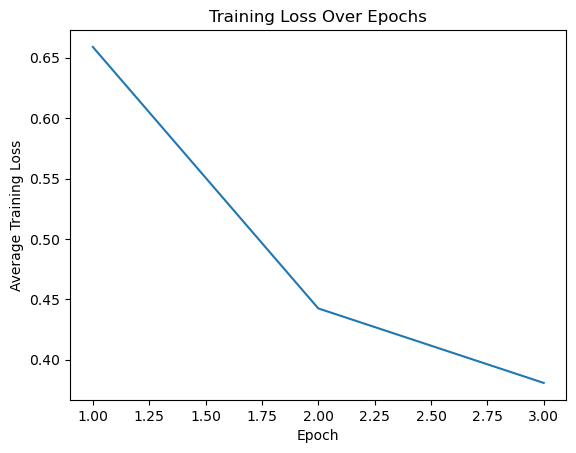

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.json',
 './fine_tuned_model/merges.txt',
 './fine_tuned_model/added_tokens.json')

In [6]:
import torch
from transformers import AdamW, GPT2LMHeadModel
import matplotlib.pyplot as plt

# Step 1: Initialize the model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))  # Resize embeddings if tokenizer was modified
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

# Step 2: Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Tracking losses for plotting
epoch_losses = []

# Step 3: Training loop
num_epochs = 3
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        input_seq, target_word = batch

        # Move input and target to device
        input_seq = input_seq.to(device)

        # Forward pass
        outputs = model(input_ids=input_seq, labels=input_seq)
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        # Track total loss
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Step 4: Plot the loss
plt.plot(range(1, num_epochs + 1), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("Training Loss Over Epochs")
plt.show()

# Step 5: Save the fine-tuned model
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")


In [1]:
# Set the pad_token_id in the model to the tokenizer's pad token and disable EOS
model.config.pad_token_id = tokenizer.pad_token_id

# Prompt for generation
prompt = "Write a random statement"
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# Attention mask for input without padding
attention_mask = torch.ones(input_ids.shape, device=device)

# Generate text with adjusted parameters
output = model.generate(
    input_ids,
    max_length=50,
    num_return_sequences=1,
    attention_mask=attention_mask,
    pad_token_id=model.config.pad_token_id,
    eos_token_id=None,  # Disable eos_token to prevent early stopping
    temperature=0.8,
    top_k=50,
    top_p=0.95
)

print(output)
# Decode and print the generated text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


NameError: name 'tokenizer' is not defined